In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from SyntheticControlMethods import Synth
from PIL import Image

In [2]:
Image.MAX_IMAGE_PIXELS = None

<h3> Guyana </h3>

As a preliminary example, we will attempt to plot the time-series of forest cover for Guyana based off of the Hansen Global Forest Change dataset. 

In [3]:
country = 'Guyana'
canopy_threshold = 30

In [4]:
im10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_060W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")

In [5]:
ar10_60 = np.array(im10_60)
ar10_70 = np.array(im10_70)

In [6]:
boundaries = gpd.read_file("../data/World_Countries__Generalized_.shp")
country_shp = boundaries[boundaries['COUNTRY'] == country].geometry

<AxesSubplot: >

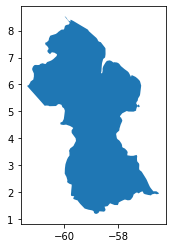

In [7]:
country_shp.plot()

In [8]:
np.sum(ar10_60 > canopy_threshold)

832161457

In [9]:
def sum_tile(tile, country_shp, topleftlat, topleftlon):

    n = len(tile)
    
    tile_df = pd.DataFrame({'x': n * [x for x in range(n)],
                   'y': np.array([n * [y] for y in range(n)]).flatten()})
    
    tile_df['lat'] = topleftlat - (tile_df['y']/n) * 10
    tile_df['lon'] = topleftlon + (tile_df['x']/n) * 10

    tile_df['cover'] = tile.flatten()

    return tile_df   

In [10]:
cover_40k = sum_tile(ar10_60, country_shp, 10, -60)

In [13]:
cover_10k = sum_tile(ar10_60_10k, country_shp, 10, -60)

In [16]:
len(cover_10k[cover_10k['cover'] > 30])/len(cover_10k)

0.52216799

In [17]:
len(cover_40k[cover_40k['cover'] > 30])/len(cover_40k)

0.520100910625

In [11]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [12]:
ar10_60_10k = rebin(ar10_60, [10000, 10000])
ar10_60_10k

array([[  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       ...,
       [ 99.75  , 100.    , 100.    , ...,   0.    ,   0.    ,   0.    ],
       [ 99.9375,  99.9375, 100.    , ...,   0.    ,   0.    ,   0.    ],
       [ 99.9375,  99.625 ,  99.9375, ...,   0.    ,   0.    ,   0.    ]])

In [18]:
def point_within_country(row, country_shp):
    point = Point(row['lon'], row['lat'])
    return country_shp.contains(point)

cover_10k['country'] = cover_10k.apply(point_within_country, axis=1, args=(country_shp,))

KeyboardInterrupt: 

In [ ]:
len(tile_df[(tile_df['country'] == True) and (tile_df['cover'] > canopy_threshold)])
len(tile_df[(tile_df['country'] == True)])

In [ ]:
def country_initial_cover(tiles, latlons, country_shp):
    cover = 0
    total = 0
    for tile, i in enumerate(tiles):
        sums = sum_tile(tile, country_shp, latlons[i][0], latlons[i][1])
        cover += sums[0]
        total += sums[1]
    return [cover, total, cover/total * 100]

In [21]:
cover_10k['geometry'] = [Point(x, y) for (x, y) in zip(cover_10k['lon'], cover_10k['lat'])]

In [24]:
cover_10k['country'] = [country_shp.contains(x) for x in cover_10k['geometry']]